In [9]:
# Cell 1 - Imports & Config
import os
import json
import joblib
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# optional XGBoost
USE_XGBOOST = True
try:
    import xgboost as xgb
except Exception:
    USE_XGBOOST = False
    print("xgboost not installed - XGBoost models will be skipped.")

# CONFIG - edit paths as needed
FEATURE_CSV = r"data\clusters\features_master_labeled_with_tentative.csv"   # fixed master CSV
OUT_DIR = r"data\ml_models"
os.makedirs(OUT_DIR, exist_ok=True)

RANDOM_STATE = 42
EXCLUDE_TENTATIVE = True       # recommended: exclude rows with performance_level_adjusted ending with _TENTATIVE
BASE_RF_N_ESTIMATORS = 500

print("FEATURE_CSV:", FEATURE_CSV)
print("OUT_DIR:", OUT_DIR)


FEATURE_CSV: data\clusters\features_master_labeled_with_tentative.csv
OUT_DIR: data\ml_models


In [10]:
# Cell 2 - Load data, prepare X, y, players, candidate feature columns
df = pd.read_csv(FEATURE_CSV)
print("Loaded row count:", len(df))
# Quick check - ensure player column is correct and not 'filtered'
print("Unique players (sample):", df['player'].unique()[:20])
print("Players count:", df['player'].nunique())

# If you used 'performance_level_adjusted', prefer that; otherwise fall back to 'performance_level'
label_col = 'performance_level_adjusted' if 'performance_level_adjusted' in df.columns else 'performance_level'
if EXCLUDE_TENTATIVE:
    if label_col in df.columns:
        mask = ~df[label_col].astype(str).str.endswith("_TENTATIVE")
        df = df[mask].reset_index(drop=True)
        print("Excluding tentative rows. Remaining rows:", len(df))
    else:
        print("Warning: adjusted label column not found; proceeding without excluding tentatives.")

# Auto-detect feature columns: numeric columns excluding metadata
exclude_meta = {'file','player','n_samples','fs_used','gmm_label','gmm_confidence',
                'performance_level','performance_level_confidence','performance_level_adjusted','_proxy_score'}
feature_cols = [c for c in df.columns if c not in exclude_meta and np.issubdtype(df[c].dtype, np.number)]
feature_cols = sorted(feature_cols)
print("Using", len(feature_cols), "features for ML. Example:", feature_cols[:10])

X = df[feature_cols].fillna(df[feature_cols].median()).values.astype(float)
y = df[label_col].astype(str).values
players = df['player'].astype(str).values

# Encode labels
le = LabelEncoder().fit(y)
y_enc = le.transform(y)
class_names = list(le.classes_)
print("Classes:", class_names)
print("Samples per class:\n", pd.Series(y).value_counts())
print("Samples per player:\n", pd.Series(players).value_counts())


Loaded row count: 35
Unique players (sample): ['Ahesan' 'Devansh' 'Jordan' 'Karan' 'Nihaal' 'Soham' 'Yadnesh']
Players count: 7
Excluding tentative rows. Remaining rows: 35
Using 190 features for ML. Example: ['Gastrocnemius left__bp_100_200', 'Gastrocnemius left__bp_20_60', 'Gastrocnemius left__bp_60_100', 'Gastrocnemius left__dur_halfmax_s', 'Gastrocnemius left__iEMG', 'Gastrocnemius left__iEMG_rel', 'Gastrocnemius left__mav', 'Gastrocnemius left__mav_rel', 'Gastrocnemius left__mdf', 'Gastrocnemius left__mean']
Classes: ['Average', 'Below-Average', 'Excellent', 'Poor']
Samples per class:
 Excellent        10
Poor             10
Below-Average     9
Average           6
Name: count, dtype: int64
Samples per player:
 Ahesan     5
Devansh    5
Jordan     5
Karan      5
Nihaal     5
Soham      5
Yadnesh    5
Name: count, dtype: int64


In [11]:
# Cell 3 - Model factory & helpers
def get_models(random_state=RANDOM_STATE):
    models = {}
    models['rf'] = RandomForestClassifier(n_estimators=BASE_RF_N_ESTIMATORS, class_weight='balanced',
                                          random_state=random_state, n_jobs=-1)
    models['lr'] = LogisticRegression(multi_class='multinomial', max_iter=2000, class_weight='balanced', random_state=random_state)
    models['svm'] = SVC(kernel='rbf', probability=False, class_weight='balanced', random_state=random_state)
    models['knn'] = KNeighborsClassifier(n_neighbors=5)
    if USE_XGBOOST:
        models['xgb'] = xgb.XGBClassifier(objective='multi:softprob', num_class=len(class_names),
                                         n_estimators=200, use_label_encoder=False, eval_metric='mlogloss',
                                         random_state=random_state)
    return models

models = get_models()
print("Models to run:", list(models.keys()))

# Helpers: metrics & plotting
def compute_aggregate_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro', zero_division=0)
    prf = precision_recall_fscore_support(y_true, y_pred, zero_division=0)
    return {"accuracy": float(acc), "f1_macro": float(f1m), "prf": prf}

def plot_and_save_confusion(y_true, y_pred, label_encoder, title, outpath):
    labels_sorted = np.unique(np.concatenate([y_true, y_pred]))
    target_names = label_encoder.inverse_transform(labels_sorted)
    cm = confusion_matrix(y_true, y_pred, labels=labels_sorted)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(outpath, dpi=200, bbox_inches='tight')
    plt.show()


Models to run: ['rf', 'lr', 'svm', 'knn', 'xgb']


In [12]:
# Cell 4 - LOPO evaluation loop (train per-fold, save fold models/scalers, collect aggregated preds)
unique_players = np.unique(players)
n_players = len(unique_players)
print("LOPO folds (players):", n_players, unique_players)

if n_players < 2:
    raise RuntimeError("LOPO requires at least 2 distinct players. Fix 'player' column before proceeding.")

# storage for aggregated results
lopo_results = {name: {"y_true": [], "y_pred": [], "folds": []} for name in models.keys()}

for fold_idx, test_player in enumerate(unique_players, start=1):
    # split
    test_mask = (players == test_player)
    train_mask = ~test_mask
    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y_enc[train_mask], y_enc[test_mask]

    if X_test.shape[0] == 0 or X_train.shape[0] == 0:
        print(f"Skipping fold for player {test_player} - no train/test samples.")
        continue

    # scale on train only
    scaler = StandardScaler().fit(X_train)
    X_train_s = scaler.transform(X_train)
    X_test_s = scaler.transform(X_test)

    for name, clf in models.items():
        clf_local = clone(clf)
        clf_local.fit(X_train_s, y_train)
        y_pred = clf_local.predict(X_test_s)

        # save fold-specific model & scaler for inspection
        model_p = os.path.join(OUT_DIR, f"{name}_fold{fold_idx}_test_{test_player}.joblib")
        scaler_p = os.path.join(OUT_DIR, f"{name}_fold{fold_idx}_scaler_test_{test_player}.joblib")
        joblib.dump(clf_local, model_p)
        joblib.dump(scaler, scaler_p)

        # collect
        lopo_results[name]['y_true'].extend(list(y_test))
        lopo_results[name]['y_pred'].extend(list(y_pred))
        lopo_results[name]['folds'].append({
            "fold": fold_idx,
            "test_player": str(test_player),
            "n_test": int(len(y_test)),
            "accuracy": float(accuracy_score(y_test, y_pred)),
            "f1_macro": float(f1_score(y_test, y_pred, average='macro', zero_division=0))
        })

    print(f"Completed LOPO fold {fold_idx}/{n_players} | test_player={test_player} | n_test={X_test.shape[0]}")


LOPO folds (players): 7 ['Ahesan' 'Devansh' 'Jordan' 'Karan' 'Nihaal' 'Soham' 'Yadnesh']
Completed LOPO fold 1/7 | test_player=Ahesan | n_test=5
Completed LOPO fold 2/7 | test_player=Devansh | n_test=5
Completed LOPO fold 3/7 | test_player=Jordan | n_test=5
Completed LOPO fold 4/7 | test_player=Karan | n_test=5
Completed LOPO fold 5/7 | test_player=Nihaal | n_test=5
Completed LOPO fold 6/7 | test_player=Soham | n_test=5
Completed LOPO fold 7/7 | test_player=Yadnesh | n_test=5


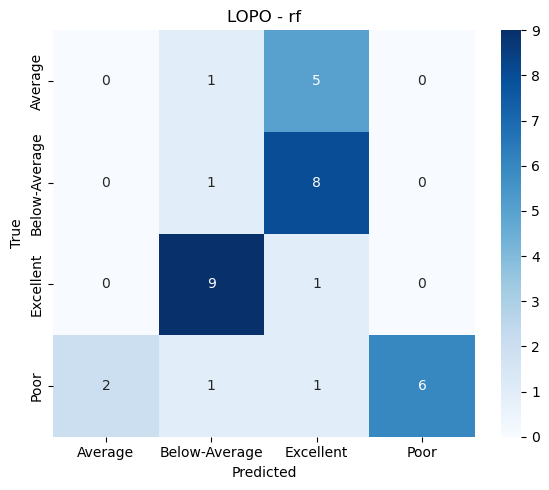

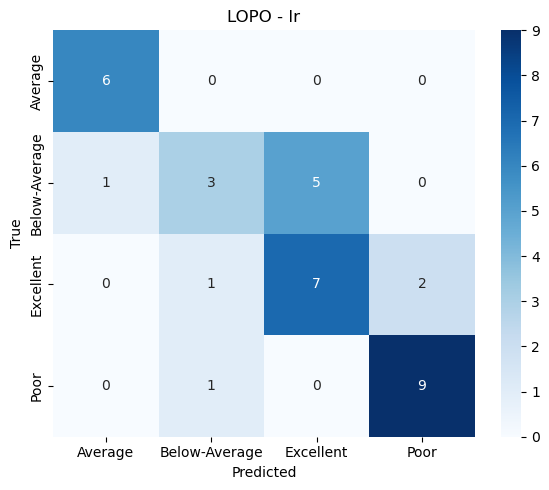

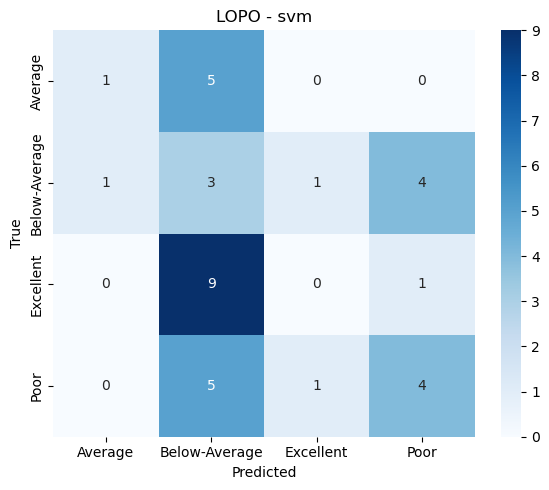

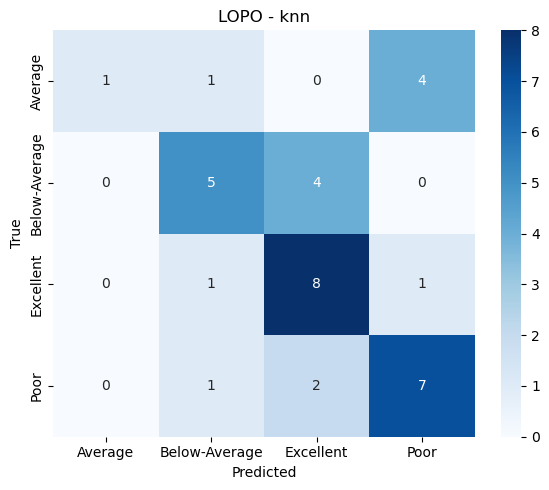

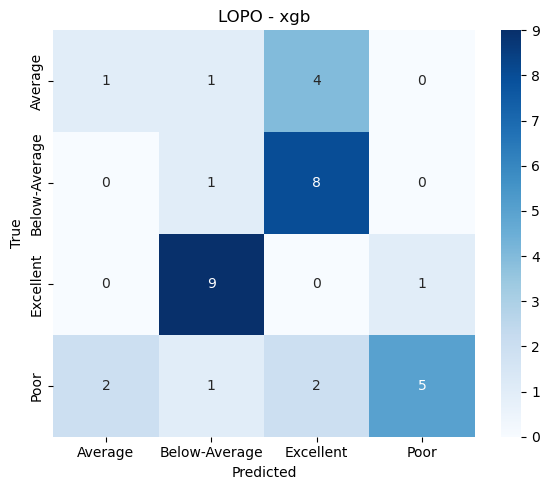

,model,accuracy,f1_macro,n_samples
0,lr,0.714286,0.711289,35
1,knn,0.600000,0.544245,35
2,xgb,0.200000,0.235615,35
3,rf,0.228571,0.231310,35
4,svm,0.228571,0.216150,35


Saved LOPO summaries to: data\ml_models


In [13]:
# Cell 5 - Aggregate LOPO metrics, save summary & produce confusion matrices + reports
summary_rows = []
for name in list(models.keys()):
    y_true = np.array(lopo_results[name]['y_true'])
    y_pred = np.array(lopo_results[name]['y_pred'])
    if y_true.size == 0:
        print(f"No predictions for model {name} (empty).")
        continue
    agg = compute_aggregate_metrics(y_true, y_pred)
    summary_rows.append({"model": name, "accuracy": agg['accuracy'], "f1_macro": agg['f1_macro'], "n_samples": int(y_true.size)})
    # save aggregated classification report
    labels_sorted = np.unique(np.concatenate([y_true, y_pred]))
    target_names = le.inverse_transform(labels_sorted)
    report_txt = classification_report(y_true, y_pred, target_names=target_names, zero_division=0)
    with open(os.path.join(OUT_DIR, f"LOPO_{name}_classification_report.txt"), "w") as f:
        f.write(report_txt)
    # confusion matrix plot
    plot_and_save_confusion(y_true, y_pred, le, f"LOPO - {name}", os.path.join(OUT_DIR, f"LOPO_{name}_confusion.png"))

# show summary table
summary_df = pd.DataFrame(summary_rows).sort_values('f1_macro', ascending=False).reset_index(drop=True)
display(summary_df)
summary_df.to_csv(os.path.join(OUT_DIR, "lopo_model_comparison_summary.csv"), index=False)
print("Saved LOPO summaries to:", OUT_DIR)


In [14]:
# Cell 6 - Train final models on ALL available (after excluding tentative if chosen) and save
# NOTE: final models trained on all data are intended for deployment/inspection only (no held-out player)
scaler_all = StandardScaler().fit(X)
X_all_s = scaler_all.transform(X)

final_models = {}
for name, clf in models.items():
    clf_final = clone(clf)
    clf_final.fit(X_all_s, y_enc)
    final_models[name] = clf_final
    joblib.dump(clf_final, os.path.join(OUT_DIR, f"{name}_final.joblib"))
joblib.dump(scaler_all, os.path.join(OUT_DIR, "final_scaler.joblib"))
joblib.dump(le, os.path.join(OUT_DIR, "label_encoder.joblib"))
pd.Series(feature_cols).to_csv(os.path.join(OUT_DIR, "feature_columns.csv"), index=False)
print("Saved final models and artifacts to:", OUT_DIR)


Saved final models and artifacts to: data\ml_models


,feature,importance
95,Rectus Femoris left__bp_20_60,0.019678
65,Hamstrings left__rms_rel,0.018211
45,Gastrocnemius__LR_mean_absdev1,0.017683
96,Rectus Femoris left__bp_60_100,0.017039
116,Rectus Femoris right__bp_100_200,0.016603
132,Rectus Femoris right__peak_rel,0.016003
118,Rectus Femoris right__bp_60_100,0.015853
117,Rectus Femoris right__bp_20_60,0.015337
133,Rectus Femoris right__rms,0.015290
130,Rectus Femoris right__mrms_peak_rel,0.014970


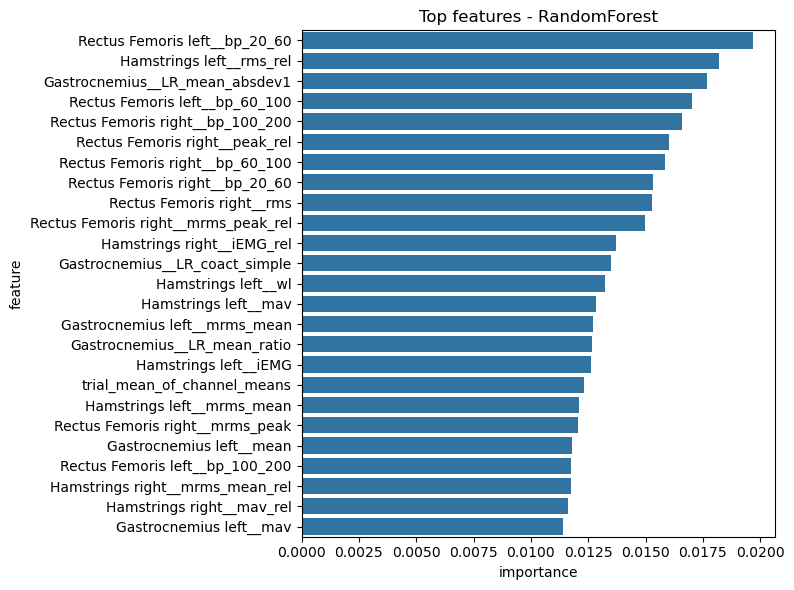

,feature,importance
0,Gastrocnemius left__bp_100_200,0.121213
20,Gastrocnemius left__time_to_peak_s,0.102689
4,Gastrocnemius left__iEMG,0.099987
130,Rectus Femoris right__mrms_peak_rel,0.083486
22,Gastrocnemius right__bp_100_200,0.072374
185,TibilaisÂ Anterior__LR_coact_simple,0.056185
158,TibilaisÂ Anterior left__rms,0.054951
184,TibilaisÂ Anterior right__wl,0.052183
74,Hamstrings right__iEMG_rel,0.049457
119,Rectus Femoris right__dur_halfmax_s,0.046721


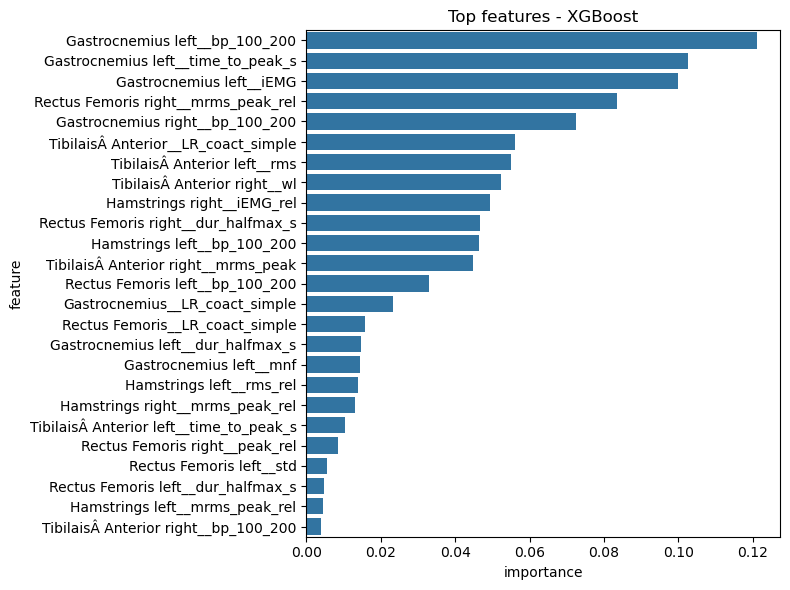

In [15]:
# Cell 7 - Feature importance / interpretation (for tree-based models only)
def show_feature_importances(clf, name, feature_names, top_n=20):
    if hasattr(clf, "feature_importances_"):
        imp = clf.feature_importances_
        imp_df = pd.DataFrame({"feature": feature_names, "importance": imp}).sort_values("importance", ascending=False)
        display(imp_df.head(top_n))
        plt.figure(figsize=(8,6))
        sns.barplot(x="importance", y="feature", data=imp_df.head(min(top_n, len(feature_names))))
        plt.title(f"Top features - {name}")
        plt.tight_layout()
        plt.show()
    else:
        print(f"{name} has no feature_importances_ attribute.")

# Try show RF importance if available in final models
if 'rf' in final_models:
    show_feature_importances(final_models['rf'], 'RandomForest', feature_cols, top_n=25)
if USE_XGBOOST and 'xgb' in final_models:
    show_feature_importances(final_models['xgb'], 'XGBoost', feature_cols, top_n=25)


In [16]:
# Cell 8 - Per-fold table & bootstrap CI for aggregated accuracy (optional)
# Save per-fold summary for best model
best_model = summary_df.iloc[0]['model'] if not summary_df.empty else 'rf'
per_fold_df = pd.DataFrame(lopo_results[best_model]['folds']).sort_values('fold')
per_fold_df.to_csv(os.path.join(OUT_DIR, f"{best_model}_lopo_per_fold.csv"), index=False)
display(per_fold_df)

# Bootstrap CI for overall accuracy (aggregated across LOPO test samples)
def bootstrap_ci_acc(y_true, y_pred, n_iter=2000, alpha=0.05):
    rng = np.random.RandomState(RANDOM_STATE)
    n = len(y_true)
    stats = []
    for _ in range(n_iter):
        idx = rng.randint(0, n, n)
        stats.append(accuracy_score(y_true[idx], y_pred[idx]))
    lo = np.percentile(stats, 100*alpha/2)
    hi = np.percentile(stats, 100*(1-alpha/2))
    return np.mean(stats), (lo, hi)

y_true_all = np.array(lopo_results[best_model]['y_true'])
y_pred_all = np.array(lopo_results[best_model]['y_pred'])
if y_true_all.size > 0:
    mean_acc, (lo, hi) = bootstrap_ci_acc(y_true_all, y_pred_all, n_iter=1000)
    print(f"Bootstrap mean accuracy: {mean_acc:.3f}, 95% CI: [{lo:.3f}, {hi:.3f}]")
    # save bootstrap summary
    with open(os.path.join(OUT_DIR, "bootstrap_summary.json"), "w") as f:
        json.dump({"mean_acc": mean_acc, "ci": [lo, hi]}, f)


,fold,test_player,n_test,accuracy,f1_macro
0,1,Ahesan,5,0.2,0.333333
1,2,Devansh,5,0.4,0.190476
2,3,Jordan,5,0.8,0.444444
3,4,Karan,5,1.0,1.000000
4,5,Nihaal,5,0.6,0.250000
5,6,Soham,5,1.0,1.000000
6,7,Yadnesh,5,1.0,1.000000


Bootstrap mean accuracy: 0.714, 95% CI: [0.571, 0.857]
